In [6]:
%load_ext autoreload
%autoreload

import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
import ptsa
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sb
from pylab import *
from copy import copy
from scipy import stats
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/SWRrefactored/code/SWR_modules/')
from SWRmodule import *
from comodulogram import *
from general import * #superVstack,findInd,findAinB
from power_functions import z_score, process_power, load_z_scored_power

base = '/home1/john/SWRrefactored'
sys.path.append(f'{base}/code/')

from load_data_numpy import load_data_np
from SWRmodule import triangleSmooth
# from comodulogram import remove_session_string, get_filtered_signal
# from fooof import FOOOF

import statsmodels.formula.api as smf
from scipy.signal import decimate, resample, hilbert, welch, spectrogram
from mne.time_frequency import tfr_array_morlet

# %load_ext autoreload
# %autoreload 2
# import numpy as np
# import sys 
# base = '/home1/efeghhi/'
# sys.path.append(f'{base}ripple_memory/analysis_code/')
# from load_data import *
# from analyze_data import *
# sys.path.append(f'{base}ripple_memory/analysis_code/pac_analyses/')
# from load_data_numpy import load_data_np
# from comodulogram import remove_session_string, get_filtered_signal

# import statsmodels.formula.api as smf
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy.signal import decimate, resample

# from mne.time_frequency import tfr_array_morlet
# from scipy.signal import hilbert
# sys.path.append('/home1/efeghhi/ripple_memory/')
# from SWRmodule import triangleSmooth

# from power_functions import z_score, process_power, load_z_scored_power

# from copy import deepcopy

# # Import the FOOOF object
# from fooof import FOOOF
# from scipy.signal import welch

# from scipy.signal import spectrogram


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
savePath = f'{base}/figures/'

In [8]:
# now let's see which electrodes display a rise in power 
from scipy.stats import ttest_rel 
from scipy.stats import wilcoxon
       
fs = 500

region_name = ['HPC']
subregion = ['ca1']
train_only=False
encoding_mode = 1
task = 'catFR1'

freq_band = 'medium_gamma'
if freq_band == 'medium_gamma':
    freq_range = [[80,120]]
if freq_band == 'low_theta':
    freq_range = [[2,4]]
if freq_band == 'both':
    freq_range = [[2,4], [80,120]]
    
# load data
dd_trials = load_data_np(encoding_mode, task, region_name=region_name, subregion=subregion, train_only=train_only)

raw_data = dd_trials['raw']
subj_elec_sess_labels = dd_trials['elec_labels'] 
subj_elec_unique, counts_se = np.unique(subj_elec_sess_labels, return_counts=True)

if encoding_mode:

    # each trial consists of 5 sec of raw data, which starts
    # 1.7 before word onset and ends 3.3 sec after word onset 
    # the data is sampled at 500 Hz
    start_time = -700
    end_time = 2300
    
    start_cutoff = 500
    end_cutoff = 2000
    
else:
       
    # relative to word vocalization, in ms
    start_roi = -1100
    end_roi = -100

    # for recall, 
    # each trial consists of 6 sec of data, centered around word recall 
    start_time = -2000
    end_time = 2000
    
    start_cutoff = 500
    end_cutoff = 2500
    

Loading data
LOADING DATA FROM: HPC FOR EXPERIMENT catFR1
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
order: C


In [9]:
bandwidth='auto'

fs = 500

# filter signal using hilbert method
filtered_sig = get_filtered_signal(raw_data, freq_range, start_cutoff, 
                                   end_cutoff, fs, bandwidth=bandwidth)
# obtain power and amplitude
filtered_sig_amp = np.real(np.abs(filtered_sig))
filtered_sig_power = process_power(filtered_sig_amp**2, subj_elec_sess_labels)
# update fs and sr_factor
fs = 50
sr_factor = 1000/fs

In [10]:
dd_trials.keys()

dict_keys(['ripple', 'clust', 'correct', 'position', 'list_num', 'subj', 'sess', 'elec_names', 'elec_labels', 'serial_pos', 'raw', 'elec_by_elec_correlation', 'trial_by_trial_correlation', 'elec_ripple_rate_array', 'category_array', 'clust_int'])

<Figure size 720x432 with 0 Axes>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

(-1.5, 1.5)

Text(0.5, 0, 'Time (s)')

Text(0.5, 1.0, 'FR')

Text(0, 0.5, 'Power (80-120 Hz)')

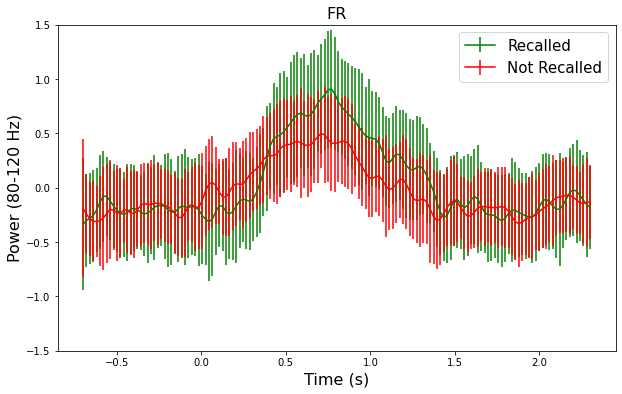

In [11]:
subjects = dd_trials['subj']
across_x_heatmap = []
unique_subjects = np.unique(subjects)
organize_by = dd_trials['elec_labels']
filt_pow = filtered_sig_power.squeeze()
power_label = 'low_theta'

# relative to word onset, in ms 
# 512 timepoints so that everything is in a power of 2
start_roi = 300
end_roi = 1300

correct_idxs = np.argwhere(dd_trials['correct']==1).squeeze()
incorrect_idxs = np.argwhere(dd_trials['correct']==0).squeeze()

# convert to indices based on start time and sampling rate factor
start_idx = int((start_roi - start_time)/sr_factor)
end_idx = int((end_roi-start_time)/sr_factor)

s_max = 0

power_across_x = []
power_correct_across_x = []
power_incorrect_across_x = []

x_array = np.linspace(-.7, 2.3, 150)

frac_correct = []

num_trials = []

for s in np.unique(organize_by):

    s_idxs = np.argwhere(organize_by==s)
    
    num_trials.append(s_idxs.shape[0])
    
    correct_s_idxs = np.intersect1d(s_idxs, correct_idxs)
    incorrect_s_idxs = np.intersect1d(s_idxs, incorrect_idxs)
    
    frac_correct.append(correct_s_idxs.shape[0]/(correct_s_idxs.shape[0]+incorrect_s_idxs.shape[0]))
    
    s_power = np.mean(filt_pow[s_idxs].squeeze(),axis=0)
    s_correct_power = np.mean(filt_pow[correct_s_idxs].squeeze(),axis=0)
    s_incorrect_power = np.mean(filt_pow[incorrect_s_idxs].squeeze(),axis=0)
    
    power_across_x.append(s_power)
    power_correct_across_x.append(s_correct_power)
    power_incorrect_across_x.append(s_incorrect_power)
    
    range_pow = np.max(s_power) - np.min(s_power)
    
    s_pow_norm = (s_power - np.min(s_power))/range_pow
    
    across_x_heatmap.append(s_pow_norm)
    
#plt.figure(figsize=(12,8))
#across_x_heatmap_np = np.stack(across_x_heatmap)
# Find the index of the maximum value in each row
#max_indices = np.argmax(across_x_heatmap_np, axis=1)
# Sort the rows based on the index of the maximum value
#sorted_indices = np.argsort(max_indices)
#sorted_heatmap = across_x_heatmap_np[sorted_indices]
#ax = sns.heatmap(sorted_heatmap)
#ax.set_xticks([0, 35, 45, 115])
#ax.set_xticklabels(['-.7', '0', '0.2', '1.6'], rotation=45, ha='right', fontsize=14)
#plt.show()



correct_power_np = np.stack(power_correct_across_x)
incorrect_power_np = np.stack(power_incorrect_across_x)
num_patients = unique_subjects.shape[0]

plt.figure(figsize=(10,6))
plt.errorbar(x_array, y=triangleSmooth(np.mean(correct_power_np,axis=0),5), 
             yerr=np.std(correct_power_np,axis=0)/np.sqrt(num_patients), color='g', label='Recalled')\

plt.errorbar(x_array, y=triangleSmooth(np.mean(incorrect_power_np,axis=0),5), 
             yerr=np.std(incorrect_power_np,axis=0)/np.sqrt(num_patients), 
            color='r', label='Not Recalled')
plt.ylim(-1.5,1.5)
plt.legend(fontsize=15)
plt.xlabel("Time (s)", fontsize=16)
plt.title("FR", fontsize=16)
plt.ylabel(f"Power (80-120 Hz)", fontsize=16)
plt.show()

In [12]:
filtered_sig_power.shape

(1, 18408, 150)

In [13]:
# in ms
# update fs and sr_factor
fs = 50
sr_factor = 1000/fs
start_time = 300
end_time = 1300
base_end_time = 0
trial_start_time = -700
start_idx = int((start_time - trial_start_time)/sr_factor)
end_idx = int((end_time - trial_start_time)/sr_factor)
base_end_idx = int((base_end_time - trial_start_time)/sr_factor)

In [16]:
# medium_gamma_power = filtered_sig_power[1]
medium_gamma_power_roi = np.mean(medium_gamma_power[:, start_idx:end_idx],axis=1)
medium_gamma_power_base = np.mean(medium_gamma_power[:, :base_end_idx],axis=1)
sorted_by_peak_gamma_idxs = np.argsort(medium_gamma_power_roi - medium_gamma_power_base)[::-1]
trial_idx_plot = sorted_by_peak_gamma_idxs[8]
plt.plot(medium_gamma_power[trial_idx_plot])
plt.show()

NameError: name 'medium_gamma_power' is not defined

In [15]:
# in ms
start_time = 300
end_time = 1300
base_end_time = 0
trial_start_time = -1700
fs = 500
sr_factor = 2
nperseg=500
start_idx = int((start_time - trial_start_time)/sr_factor)
end_idx = int((end_time - trial_start_time)/sr_factor)
base_end_idx = int((base_end_time - trial_start_time)/sr_factor)

trial_foof = raw_data[trial_idx_plot]
f, Pxx = welch(trial_foof[start_idx:end_idx], fs=fs, nperseg=nperseg)

# Initialize a model object
fm = FOOOF(peak_width_limits=[2,12])

# Set the frequency range to fit the model
freq_range = [0.1,150]

# Report: fit the model, print the resulting parameters, and plot the reconstruction
fm.report(f, Pxx, freq_range)

NameError: name 'trial_idx_plot' is not defined

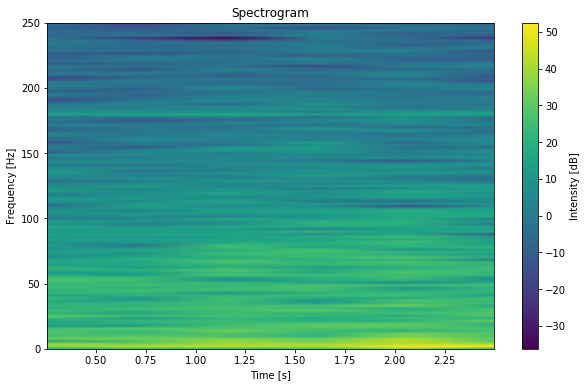

In [131]:
# Compute the spectrogram
frequencies, times, Sxx = spectrogram(trial_foof[500:-500], fs)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Spectrogram')
plt.colorbar(label='Intensity [dB]')
plt.show()

In [ ]:
# Initialize a model object
fm = FOOOF(peak_width_limits=[1.2,12], aperiodic_mode='knee')

# Set the frequency range to fit the model
freq_range = [0.1,150]

# Report: fit the model, print the resulting parameters, and plot the reconstruction
fm.report(f, Pxx_mean, freq_range)

In [77]:
list_length = 12
semantic_chaining_idxs = []

def compute_semantic_chaining_idxs(recalled_position, cat_list):
    
    '''
    :param list recalled_position: indices of items that were recalled, in the
    order they were recalled
    :param list cat_list: category of each item during encoding (length is
    always the same, equal to list length)
    
    This function returns a list of length cat_list, where recalled elements 
    are assigned a value of 1, recalled and semantically grouped elements 
    are assigned a value of 2, and not recalled items are assigned a value of 0.
    
    This function uses the most liberal definition of a semantically grouped item.
    An item is semantically group if either of its recall neighbors are from the 
    same semantic category. 
    '''
    
    # remove intrusions and duplicates
    recalled_position = [p for p in recalled_position if (p>0) & (p<13)]
    recalled_position = list(dict.fromkeys(recalled_position))
    
    num_recalls = len(recalled_position)
    last_idx = num_recalls - 1
        
    sc_list = [0 for i in range(len(cat_list))]
    
    # if 0 or 1 item was recalled, semantic chaining is not possible
    if len(recalled_position) < 2:
        return sc_list
   
    recalled_categories = []
    for r in recalled_position:
        recalled_categories.append(cat_list[r-1])
        

    for i, (r, rc) in enumerate(zip(recalled_position,recalled_categories)):
        
        if i == 0:
            if recalled_categories[i] == recalled_categories[i+1]:
                sc_list[r-1] = 2
            else:
                sc_list[r-1] = 1
            
        elif (i>0) and (i<last_idx):
            
            if recalled_categories[i] == recalled_categories[i+1]:
                sc_list[r-1] = 2
            elif recalled_categories[i] == recalled_categories[i-1]:
                sc_list[r-1] = 2
            else:
                sc_list[r-1] = 1
            
        elif i == last_idx:
            if recalled_categories[i] == recalled_categories[i-1]:
                sc_list[r-1] = 2
            else:
                sc_list[r-1] = 1

    return sc_list


for elec in np.unique(dd_trials['elec_labels']):
    
    semantic_chaining_elec = []
    
    elec_idxs = np.argwhere(elec==dd_trials['elec_labels']).squeeze()
    
    cat_list_elec = dd_trials['category_array'][elec_idxs]
    recalled_position_elec = dd_trials['position'][elec_idxs]
    correct_elec = dd_trials['correct'][elec_idxs]
    clust_elec = dd_trials['clust_int'][elec_idxs]
    
    num_trials_elec = elec_idxs.shape[0]
    
    for i in range(0, num_trials_elec, list_length):

        cat_list = cat_list_elec[i:i+list_length]

        # encoding positions of recalled items for that list 
        recalled_position = recalled_position_elec[i]

        sc = compute_semantic_chaining_idxs(recalled_position, cat_list)
        semantic_chaining_elec.extend(sc)

    semantic_chaining_idxs.extend(semantic_chaining_elec)

In [78]:
values, counts = np.unique(semantic_chaining_idxs, return_counts=True)
print(values, counts)

[0 1 2] [37532  3903 20413]


In [79]:
cat_list

array(['Weather', 'Weather', 'Vegetables', 'Vegetables', 'Fruit', 'Fruit',
       'Weather', 'Weather', 'Fruit', 'Fruit', 'Vegetables', 'Vegetables'],
      dtype='<U14')

In [10]:
filtered_sig_power.shape

(1, 11808, 150)

IndexError: index 1 is out of bounds for axis 0 with size 1

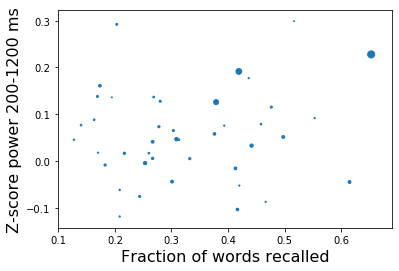

In [118]:
# 200 to 1200 ms
patient_power_word_roi = np.mean(np.stack(power_across_x)[:, 45:95],axis=1)
plt.scatter(frac_correct, patient_power_word_roi, s=50*np.array(num_trials)/np.max(num_trials))
plt.xlabel("Fraction of words recalled", fontsize=16)
plt.ylabel("Z-score power 200-1200 ms", fontsize=16)
plt.show()

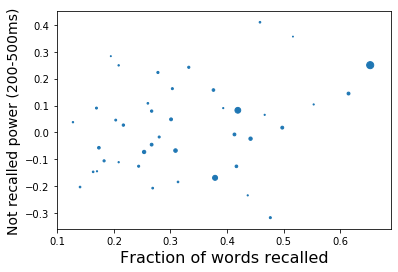

In [128]:
start_idx = 45
end_idx = 60
patient_power_word_roi = np.mean(np.stack(power_incorrect_across_x)[:, start_idx:end_idx],axis=1)
plt.scatter(frac_correct, patient_power_word_roi, s=50*np.array(num_trials)/np.max(num_trials))
plt.xlabel("Fraction of words recalled", fontsize=16)
plt.ylabel("Not recalled power (200-500ms)", fontsize=14)
plt.show()

In [91]:
correct_power_np.shape

(19, 150)

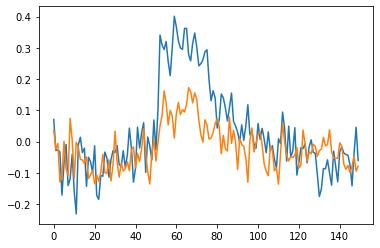

In [82]:
plt.plot(np.mean(filt_pow[correct_idxs].squeeze(), axis=0))
plt.plot(np.mean(filt_pow[incorrect_idxs].squeeze(), axis=0))

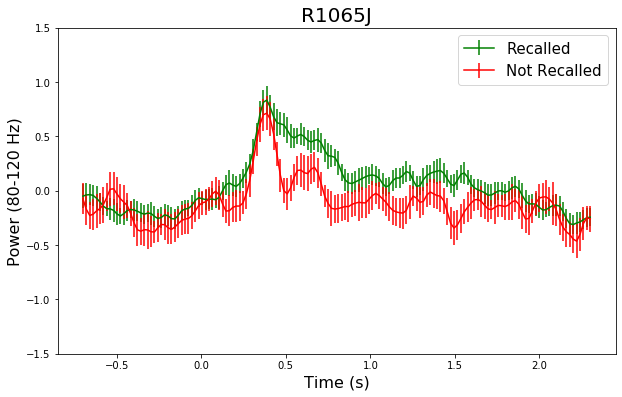

In [53]:
star_elecs = [x for x in subj_elec_sess_labels if 'R1065J' in x]

correct_idxs = np.argwhere(dd_trials['correct']==1).squeeze()
clust_idxs = np.argwhere(dd_trials['clust_int'] >1).squeeze()
not_clust_idxs = np.setdiff1d(correct_idxs, clust_idxs)
incorrect_idxs = np.argwhere(dd_trials['correct']==0).squeeze()

store_clust = []
store_not_clust = []
store_correct = []
store_incorrect = []
plt.figure(figsize=(10,6))


for star_elec in np.unique(star_elecs):
    
    star_elec_idxs = np.argwhere(subj_elec_sess_labels==star_elec).squeeze()
    
    star_elec_idxs_clust = np.intersect1d(star_elec_idxs, clust_idxs)
    star_elec_idxs_not_clust = np.intersect1d(star_elec_idxs, not_clust_idxs)
    star_elec_idxs_correct = np.intersect1d(star_elec_idxs, correct_idxs)
    star_elec_idxs_incorrect = np.intersect1d(star_elec_idxs, incorrect_idxs)

    star_elec_pow_clust = np.mean(filt_pow[star_elec_idxs_clust].squeeze(),axis=0)
    star_elec_pow_not_clust = np.mean(filt_pow[star_elec_idxs_not_clust].squeeze(),axis=0)
    star_elec_pow_correct = np.mean(filt_pow[star_elec_idxs_correct].squeeze(),axis=0)
    star_elec_pow_incorrect = np.mean(filt_pow[star_elec_idxs_incorrect].squeeze(),axis=0)
    
    
    store_clust.append(star_elec_pow_clust)
    store_not_clust.append(star_elec_pow_not_clust)
    store_correct.append(star_elec_pow_correct)
    store_incorrect.append(star_elec_pow_incorrect)
    
    
    #plt.plot(x_array, star_elec_pow_correct, color='green', alpha=0.05)
    #plt.plot(x_array, star_elec_pow_incorrect, color='red', alpha=0.05)
    


clust_np = np.stack(store_clust)
not_clust_np = np.stack(store_not_clust)
correct_np = np.stack(store_correct)
incorrect_np = np.stack(store_incorrect)
num_elecs = np.unique(star_elecs).shape[0]
    
#plt.errorbar(x_array, y=triangleSmooth(np.mean(clust_np,axis=0),5), 
#             yerr=np.std(clust_np,axis=0)/np.sqrt(num_elecs), color='b', label='Clust')
#plt.errorbar(x_array, y=triangleSmooth(np.nanmean(not_clust_np,axis=0),5), 
#             yerr=np.nanstd(not_clust_np,axis=0)/np.sqrt(num_elecs), color='purple', label='Not Clust')

#plt.errorbar(x_array, y=triangleSmooth(np.mean(not_clust_np,axis=0),5), 
#             yerr=np.std(not_clust_np,axis=0)/np.sqrt(num_elecs))

plt.errorbar(x_array, y=triangleSmooth(np.mean(correct_np,axis=0),5), 
             yerr=np.std(correct_np,axis=0)/np.sqrt(num_elecs), color='g', label='Recalled')
plt.errorbar(x_array, y=triangleSmooth(np.mean(incorrect_np,axis=0),5), 
             yerr=np.std(incorrect_np,axis=0)/np.sqrt(num_elecs), 
            color='r', label='Not Recalled')
plt.ylim(-1.5,1.5)
plt.legend(fontsize=15)
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("Power (80-120 Hz)", fontsize=16)
plt.title('R1065J', fontsize=20)
plt.show()

    